In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
df = pd.read_csv("energydata_complete.csv")
df['date'] = pd.to_datetime(df['date'])
df.head()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,...,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,...,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,...,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
3,2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,...,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389
4,2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,...,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


In [3]:
df['Appliances_kWh'] = df['Appliances'] / 1000

In [4]:
df['hour'] = df['date'].dt.hour
df['day'] = df['date'].dt.day
df['month'] = df['date'].dt.month
df['weekday'] = df['date'].dt.weekday
df['is_weekend'] = (df['weekday'] >= 5).astype(int)

In [5]:
temp_cols = [f'T{i}' for i in range(1,10)]
hum_cols = [f'RH_{i}' for i in range(1,10)]

df['avg_indoor_temp'] = df[temp_cols].mean(axis=1)
df['avg_indoor_humidity'] = df[hum_cols].mean(axis=1)

In [11]:
df['activity_index'] = (
    (df['hour'].between(6,9)) |
    (df['hour'].between(18,22))
).astype(int)

In [13]:
df['lag_1'] = df['Appliances_kWh'].shift(1)
df['lag_2'] = df['Appliances_kWh'].shift(2)
df['rolling_mean_3'] = df['Appliances_kWh'].rolling(3).mean()

df.dropna(inplace=True)

In [15]:
features = [
    'hour', 'is_weekend', 'activity_index',
    'T_out', 'RH_out', 'Windspeed',
    'avg_indoor_temp', 'avg_indoor_humidity',
    'lag_1', 'lag_2', 'rolling_mean_3'
]

X = df[features]
y = df['Appliances_kWh']

In [17]:
split = int(len(df) * 0.8)

X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

In [19]:
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

In [21]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [23]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train_log)
y_lr = np.expm1(lr.predict(X_test_scaled))

In [25]:
rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=10,
    min_samples_leaf=20,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train_log)
y_rf = np.expm1(rf.predict(X_test))

In [27]:
gb = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.03,
    max_depth=3,
    subsample=0.8,
    random_state=42
)
gb.fit(X_train, y_train_log)
y_gb = np.expm1(gb.predict(X_test))

In [28]:
y_ensemble = 0.2*y_lr + 0.4*y_rf + 0.4*y_gb

In [29]:
def smape(y_true, y_pred):
    return np.mean(
        2 * np.abs(y_pred - y_true) /
        (np.abs(y_true) + np.abs(y_pred) + 1e-6)
    ) * 100

def evaluate(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    s = smape(y_true, y_pred)
    return rmse, r2, s

In [33]:
results = pd.DataFrame({
    "Model": ["Linear Regression", "Random Forest", "Gradient Boosting", "Ensemble"],
    "RMSE (kWh)": [
        evaluate(y_test, y_lr)[0],
        evaluate(y_test, y_rf)[0],
        evaluate(y_test, y_gb)[0],
        evaluate(y_test, y_ensemble)[0]
    ],
    "R2 Score": [
        evaluate(y_test, y_lr)[1],
        evaluate(y_test, y_rf)[1],
        evaluate(y_test, y_gb)[1],
        evaluate(y_test, y_ensemble)[1]
    ],
    "SMAPE (%)": [
        evaluate(y_test, y_lr)[2],
        evaluate(y_test, y_rf)[2],
        evaluate(y_test, y_gb)[2],
        evaluate(y_test, y_ensemble)[2]
    ]
})

results

,Model,RMSE (kWh),R2 Score,SMAPE (%)
0,Linear Regression,0.006772,0.994466,4.527901
1,Random Forest,0.019269,0.955202,4.627054
2,Gradient Boosting,0.016199,0.968340,9.245271
3,Ensemble,0.013230,0.978882,5.700761


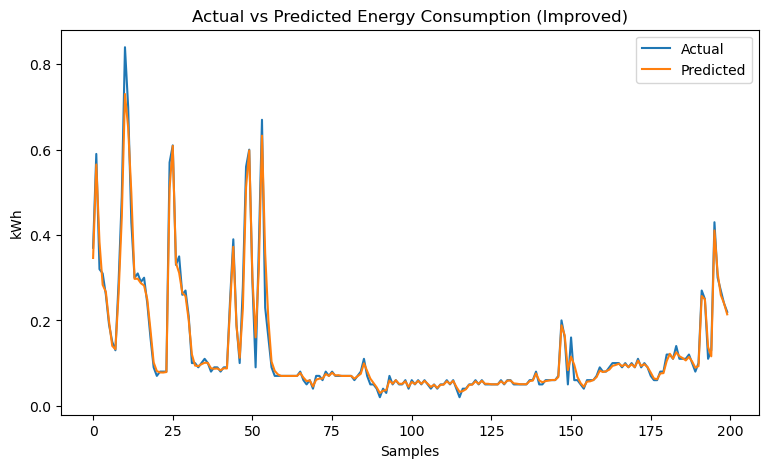

In [35]:
plt.figure(figsize=(9,5))
plt.plot(y_test.values[:200], label="Actual")
plt.plot(y_ensemble[:200], label="Predicted")
plt.legend()
plt.title("Actual vs Predicted Energy Consumption (Improved)")
plt.ylabel("kWh")
plt.xlabel("Samples")
plt.show()

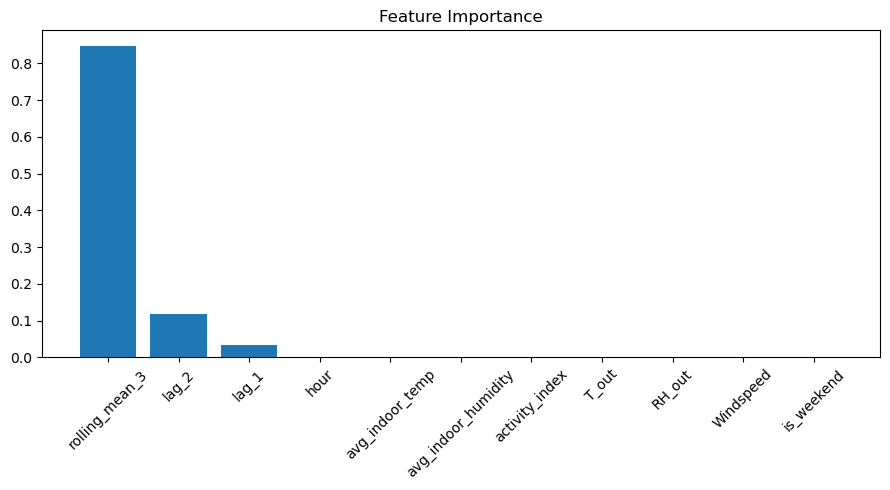

In [37]:
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(9,5))
plt.bar(range(len(features)), importances[indices])
plt.xticks(range(len(features)), np.array(features)[indices], rotation=45)
plt.title("Feature Importance")
plt.tight_layout()
plt.show()

In [39]:
CO2_FACTOR = 0.82  # kg CO2 per kWh

df_results = X_test.copy()
df_results['Predicted_kWh'] = y_ensemble
df_results['CO2_kg'] = df_results['Predicted_kWh'] * CO2_FACTOR

df_results[['Predicted_kWh', 'CO2_kg']].head()

,Predicted_kWh,CO2_kg
15788,0.346244,0.283920
15789,0.565275,0.463526
15790,0.383772,0.314693
15791,0.283263,0.232276
15792,0.266846,0.218813


In [41]:
import joblib

joblib.dump(lr, "linear_model.pkl")
joblib.dump(rf, "random_forest_model.pkl")
joblib.dump(gb, "gradient_boost_model.pkl")
joblib.dump(scaler, "scaler.pkl")

['scaler.pkl']